# MOFAFLEX vs MEFISTO on Mouse Brain Visium Data

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
parent_dir = os.path.abspath('..')
sys.path.append(parent_dir)

import plotting_settings
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import mofax as mofa
import mofaflex as mfl
from mofaflex.tl import match
from plotnine import *
import os

from data_loader import load_mefisto_visium

colors = np.concat(
    [sns.cubehelix_palette(start=0.2, rot=-.3, as_cmap=True)(np.linspace(0, 1, 128))[::-1],
     sns.cubehelix_palette(start=-0.2, rot=0.6, as_cmap=True)(np.linspace(0, 1, 128))
    ]
    , axis=0
)

/data/florin/micromamba/envs/mofaflex/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
data = load_mefisto_visium()

/data/florin/mofaflex_project/mofaflex-analysis/comparison_mefisto_visium/data_loader.py:9: FutureWarning: Use `squidpy.read.visium` instead.
/data/florin/micromamba/envs/mofaflex/lib/python3.13/site-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/data/florin/micromamba/envs/mofaflex/lib/python3.13/site-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/data/florin/micromamba/envs/mofaflex/lib/python3.13/site-packages/scanpy/preprocessing/_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
/data/florin/mofaflex_project/mofaflex-analysis/comparison_mefisto_visium/data_loader.py:31: ImplicitModificationWarning: Setting element `.obsm['spatial']` of view, initializing view as actual.


In [3]:
mefisto_model = mofa.mofa_model("models/mefisto.hdf5")
z_mefisto = pd.DataFrame(
    mefisto_model.factors["group1"][:].T,
    index=mefisto_model.samples["group1"],
    columns=[f"Factor {i+1}" for i in range(mefisto_model.nfactors)],
) / 10

w_mefisto = {}
w_mefisto["mRNA"] = pd.DataFrame(
    mefisto_model.weights["rna"][:].T,
    index=mefisto_model.features["rna"],
    columns=[f"Factor {i+1}" for i in range(mefisto_model.nfactors)]
) * 10

In [6]:
z_mofaflex = {}
w_mofaflex = {}
mofaflex_model = {}
for seed in range(10):
    mofaflex_model[seed] = mfl.MOFAFLEX.load(f"models/mofaflex_{seed}")
    z_mofaflex[seed] = mofaflex_model[seed].get_factors()['group_1']
    w_mofaflex[seed] = {}
    w_mofaflex[seed]["mRNA"] = mofaflex_model[seed].get_weights()["rna"].T

### Factor matching based on correlation

In [8]:
for seed in range(10):
    z_mefisto_inds, z_mofaflex_inds, z_signs = match(z_mefisto.values, z_mofaflex[seed].values, axis=-1)

    z_mofaflex[seed] = z_mofaflex[seed].iloc[:, z_mofaflex_inds]
    z_mofaflex[seed] = z_mofaflex[seed] * z_signs.reshape(1, -1)
    z_mofaflex[seed].columns = [f"Factor {i+1}" for i in range(z_mofaflex[seed].shape[1])]

    for view in w_mofaflex[seed].keys():
        w_mofaflex[seed][view] = w_mofaflex[seed][view].iloc[:, z_mofaflex_inds]
        w_mofaflex[seed][view] = w_mofaflex[seed][view] * z_signs.reshape(1, -1)
        w_mofaflex[seed][view].columns = [f"Factor {i+1}" for i in range(w_mofaflex[seed][view].shape[1])]

### Correlation plots

/data/florin/micromamba/envs/mofaflex/lib/python3.13/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 2 x 4 in image.
/data/florin/micromamba/envs/mofaflex/lib/python3.13/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: plots/correlations.pdf


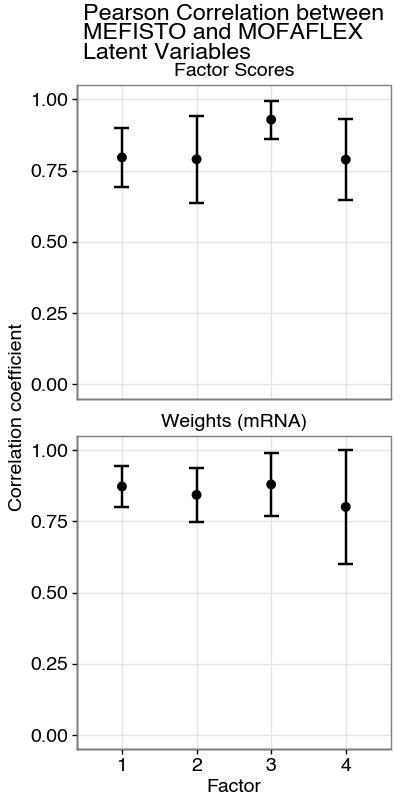

In [11]:
seeds = list(z_mofaflex.keys())
views = list(w_mofaflex[seeds[0]].keys())
n_factors = z_mofaflex[0].shape[1]

df = []
for seed in seeds:
    corr = []
    for i in range(n_factors):
        corr.append(pearsonr(z_mofaflex[seed].iloc[:, i], z_mefisto.iloc[:, i])[0])
    df.append(pd.DataFrame(corr, columns=["corr"]))
    df[-1]["seed"] = seed
    df[-1]["factor"] = [f"{i+1}" for i in range(n_factors)]
    df[-1]["lv"] = "Factor Scores"

    for view in views:
        corr = []
        for i in range(n_factors):
            corr.append(pearsonr(w_mofaflex[seed][view].iloc[:, i], w_mefisto[view].iloc[:, i])[0].item())
        df.append(pd.DataFrame(corr, columns=[f"corr"]))
        df[-1]["seed"] = seed
        df[-1]["factor"] = [f"{i+1}" for i in range(n_factors)]
        df[-1]["lv"] = f"Weights ({view})"

df = pd.concat(df, axis=0)

df = df.groupby(["factor", "lv"])["corr"].aggregate(["mean", "std"]).reset_index()
df["min"] = df["mean"] - df["std"]
df["max"] = df["mean"] + df["std"]
df["factor"] = pd.Categorical(df["factor"], categories=[f"{i+1}" for i in range(n_factors)], ordered=True)
df["min"] = np.clip(df["min"], a_min=0., a_max=1.)
df["max"] = np.clip(df["max"], a_min=0., a_max=1.)

plot = (
    ggplot(df, aes(x="factor", y="mean", group="lv"))
    + geom_point(size=1.)
    + geom_errorbar(aes(ymin="min", ymax="max"), width=0.2)
    + facet_wrap("~lv", scales="fixed", ncol=1)
    + theme(
        figure_size=(2, 4),
        panel_spacing_y=0.05
    )
    + labs(x="Factor", y="Correlation coefficient", title="Pearson Correlation between\nMEFISTO and MOFAFLEX\nLatent Variables")
    + ylim(0, 1)
)

ggsave(plot, "plots/correlations.pdf")
plot.show()

### Weights scatter plots

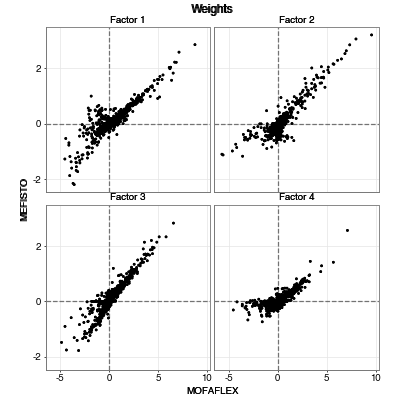

In [12]:
factors = ["Factor 1", "Factor 2", "Factor 3", "Factor 4"]
seed = 1

df_list = []
for factor in factors:
    df = pd.DataFrame(w_mofaflex[seed][view][factor])
    df.columns = ["weight_mofaflex"]
    df["weight_mefisto"] = w_mefisto[view][factor]
    df["weight_mofaflex_abs"] = df["weight_mofaflex"].abs()
    df["weight_mefisto_abs"] = df["weight_mefisto"].abs()
    df["factor"] = factor
    df_list.append(df)

# Concatenate all the DataFrames
df_all = pd.concat(df_list, ignore_index=True)

plot = (
    ggplot(df_all, aes(x="weight_mofaflex", y="weight_mefisto"))
    + geom_point(size=.1, raster=True)
    + labs(x="MOFAFLEX", y="MEFISTO", title="Weights")
    + theme(figure_size=(4, 4))
    + geom_hline(yintercept=0, linetype='dashed', color='black', alpha=0.3)
    + geom_vline(xintercept=0, linetype='dashed', color='black', alpha=0.3)
    + facet_wrap("~factor", scales="fixed")
)

fig = plot.draw()
fig.savefig("plots/weights.pdf", dpi=300)
plot.show()

### Factor covariate plots

/data/florin/micromamba/envs/mofaflex/lib/python3.13/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 6 x 2 in image.
/data/florin/micromamba/envs/mofaflex/lib/python3.13/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: plots/mofaflex_factors.pdf


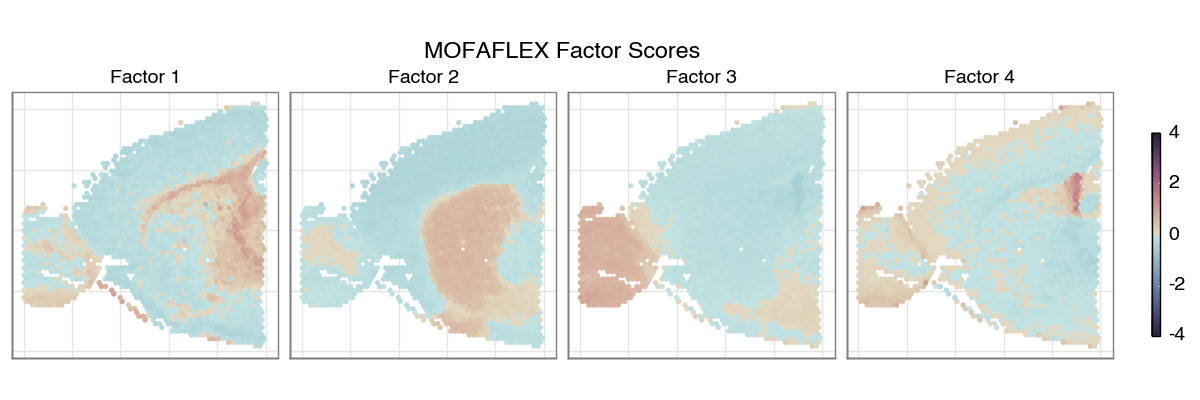

In [14]:
seed = 1

covariates_df = pd.DataFrame(mofaflex_model[seed].covariates["group_1"], columns=["x", "y"])
factors_df = pd.DataFrame(z_mofaflex[seed], columns=[f"Factor {i+1}" for i in range(z_mofaflex[seed].shape[1])])
covariates_df.index = factors_df.index
df = pd.concat([covariates_df, factors_df], axis=1)
df["y"] = -df["y"]
df_long = df.melt(id_vars=["x", "y"], value_vars=[f"Factor {i}" for i in range(1, 5)], var_name="Factor", value_name="Score")

plot = (
    ggplot(df_long, aes(x="x", y="y", color="Score"))
    + geom_point(size=0.1, raster=True)
    + theme(
        figure_size=(6, 2),
        axis_text_x=element_blank(),
        axis_text_y=element_blank(),
        axis_ticks_major_x=element_blank(),
        axis_ticks_major_y=element_blank(),
        legend_key_width=3.,
    )
    + labs(x="", y="", color="", title="MOFAFLEX Factor Scores")
    + coord_fixed(ratio=1)
    #+ scale_color_gradient2(low="#0571b0", mid="#f7f7f7", high="#B2182B", midpoint=0)
    + scale_color_gradientn(colors=colors, limits=(-4, 4))
    + facet_wrap("~Factor", nrow=1)
)

ggsave(plot, "plots/mofaflex_factors.pdf", dpi=300)
plot.show()

/data/florin/micromamba/envs/mofaflex/lib/python3.13/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 6 x 2 in image.
/data/florin/micromamba/envs/mofaflex/lib/python3.13/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: plots/mefisto_factors.pdf


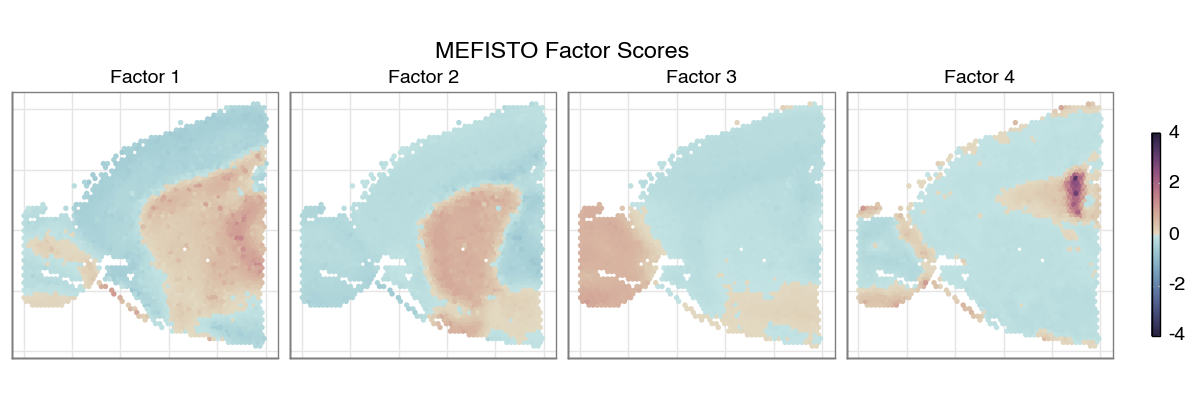

In [15]:
covariates_df = pd.DataFrame(mofaflex_model[1].covariates["group_1"], columns=["x", "y"])
factors_df = pd.DataFrame(z_mefisto, columns=[f"Factor {i+1}" for i in range(z_mefisto.shape[1])])
covariates_df.index = factors_df.index
df = pd.concat([covariates_df, factors_df], axis=1)
df["y"] = -df["y"]
df_long = df.melt(id_vars=["x", "y"], value_vars=[f"Factor {i}" for i in range(1, 5)], var_name="Factor", value_name="Score")

plot = (
    ggplot(df_long, aes(x="x", y="y", color="Score"))
    + geom_point(size=0.1, raster=True)
    + theme(
        figure_size=(6, 2),
        axis_text_x=element_blank(),
        axis_text_y=element_blank(),
        axis_ticks_major_x=element_blank(),
        axis_ticks_major_y=element_blank(),
        legend_key_width=3.,
    )
    + labs(x="", y="", color="", title="MEFISTO Factor Scores")
    + coord_fixed(ratio=1)
    + scale_color_gradientn(colors=colors, limits=(-4, 4))
    + facet_wrap("~Factor", nrow=1)
)

ggsave(plot, "plots/mefisto_factors.pdf", dpi=300)
plot.show()